In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

from sklearn.manifold import TSNE 

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import umap

from sklearn.metrics import silhouette_score

In [2]:
scaled_df=pd.read_csv('../data/processed/mall_customers_processed.csv')
scaled_df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,-1.424569,-1.738999,-0.434801,1.128152
1,-1.281035,-1.738999,1.195704,1.128152
2,-1.352802,-1.700830,-1.715913,-0.886405
3,-1.137502,-1.700830,1.040418,-0.886405
4,-0.563369,-1.662660,-0.395980,-0.886405


In [3]:
# Even though the data are scaled, sometimes features may not be informative. So the choice of important features is necessary. 
# On this behalf, heatmap and variance thresholding can be used to remove redundant and near-constant features
# Correlation heatmap to remove redundant features.
# Variance thresholding to remove near-constant features.

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
reduced_df = selector.fit_transform(scaled_df)

(200, 4) (200, 4)


<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

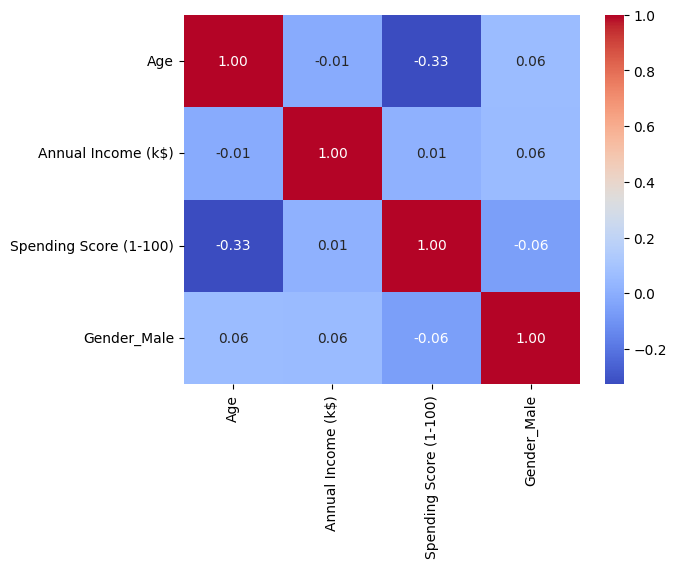

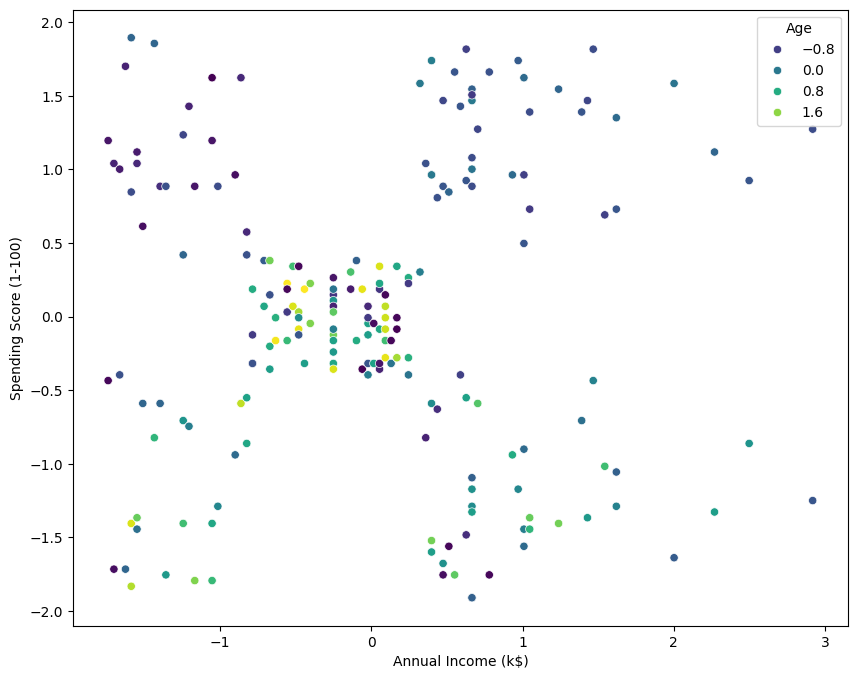

In [4]:
print(reduced_df.shape, scaled_df.shape) 
# As we can see, the number of features in scaled_df and reduced_df is same. So have a look at correlation heatmap also
sns.heatmap(scaled_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
# From the correlation heatmap, we can see that Age and Spending Score are highly correlated with each other. 
# Gender_Male is least correlated with other features. Hence, it can be removed.
# Even though Annual Income shows least correlation with other features, it is an important to distinguish high-spenders vs. low-spenders.
plt.figure(figsize=(10, 8))
sns.scatterplot(data=scaled_df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Age', palette='viridis')

In [5]:
scaled_df.drop(columns=['Gender_Male'], inplace=True)
scaled_df.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


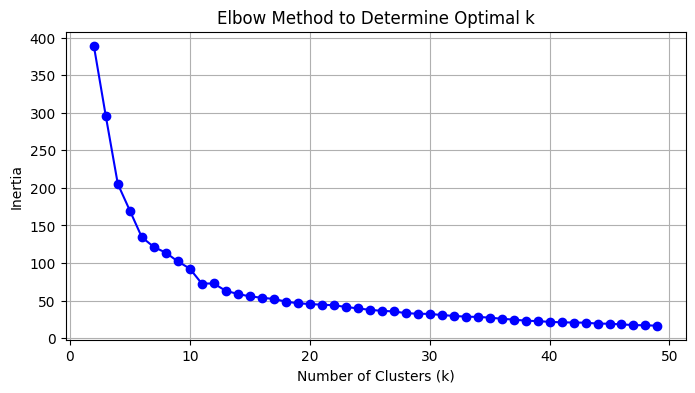

In [6]:
# Determining the optimal number of clusters using the Elbow Method and Silhouette Score
inertia = []
score = []

K = range(2, 50)  # Start from k=2 for silhouette score

for k in K:
    kmeans = KMeans(n_clusters=k, tol=1e-9, random_state=42)
    clusters = kmeans.fit_predict(scaled_df)
    inertia.append(kmeans.inertia_)
    # score.append(silhouette_score(scaled_df, clusters))

# Elbow Plot
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.grid()
plt.show()

# Silhouette Plot
# plt.figure(figsize=(8, 4))
# plt.plot(K, score, 'ro-')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score for Different k Values')
# plt.grid()
# plt.show()

In [ ]:

kmeans = KMeans(n_clusters=6, tol=1e-12, max_iter=10000,random_state=42)
clusters = kmeans.fit_predict(scaled_df)
score=silhouette_score(scaled_df, clusters)
score


0.43106526216603014

In [ ]:
# Data reduction using t-SNE and clustering using k-means
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=3000)
tsne_data = tsne.fit_transform(scaled_df)

kmeans = KMeans(n_clusters=6, tol=1e-12, max_iter=10000,random_state=42)
clusters = kmeans.fit_predict(tsne_data)
score=silhouette_score(tsne_data, clusters)
score


/home/remyakommadath/all_env/customer_segmentation/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


0.611192

In [ ]:
# Data reduction using t-SNE and clustering using Agglomerative Clustering
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=3000)
tsne_data = tsne.fit_transform(scaled_df)
for k in range(2, 20):
    cluster = AgglomerativeClustering(n_clusters=k)
    labels = cluster.fit_predict(scaled_df)
    score = silhouette_score(scaled_df, labels)
    print(f'k={k}, score={score:.4f}')
# Clustering with Agglomerative Clustering is not giving better silhouette score than k-means clustering.

/home/remyakommadath/all_env/customer_segmentation/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


k=2, score=0.3180
k=3, score=0.3215
k=4, score=0.3615
k=5, score=0.3900
k=6, score=0.4201
k=7, score=0.3983
k=8, score=0.3665
k=9, score=0.3754
k=10, score=0.3809
k=11, score=0.3812
k=12, score=0.3536
k=13, score=0.3558
k=14, score=0.3532
k=15, score=0.3454
k=16, score=0.3427
k=17, score=0.3392
k=18, score=0.3439
k=19, score=0.3419


In [ ]:
# Data reduction using t-SNE and clustering using DBSCAN
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=3000)
tsne_data = tsne.fit_transform(scaled_df)
db = DBSCAN(eps=0.5, min_samples=5)
labels = db.fit_predict(scaled_df)

# filter out noise
filtered = labels[labels != -1]
if len(set(filtered)) > 1:
    score = silhouette_score(scaled_df[labels != -1], filtered)
    print(f'DBSCAN score: {score:.4f}')

# Clustering with DBSCAN is not giving better silhouette score than k-means clustering.

/home/remyakommadath/all_env/customer_segmentation/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


DBSCAN score: 0.4817


In [ ]:


reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_data = reducer.fit_transform(scaled_df)

k=2, score=0.9515
k=3, score=0.6006
k=4, score=0.6234
k=5, score=0.5705
k=6, score=0.2732
k=7, score=0.3140
k=8, score=0.3207
k=9, score=0.3537
k=10, score=0.4028
k=11, score=0.4135
k=12, score=0.4177
k=13, score=0.4070
k=14, score=0.4048
k=15, score=0.4163
k=16, score=0.3948
k=17, score=0.3974
k=18, score=0.3946
k=19, score=0.3585
